In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import math as mt
import streamlit as st
import plotly.express as px
import matplotlib.pyplot as pt
import seaborn as sns

In [2]:
# Read dataset
df = pd.read_csv('games.csv')

# Prepare Data

- Perform exploratory data analysis and correct missing values, normalize data, and add columns for calculations later on.

In [3]:
# Initial data preview
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


**Initial Observations**
- Column names have inconsistent capitalization. We will format all names to lower case
- It appears there is a total of 16175 values. However, `Name`, `Year_of_Release`, `Genre`, `Critic_Score`, `User_Score`, and `Rating` all have null values. We will need to fill.
- `Year_of_Release` should be int64 type. `User_Score` should be float64.
- `User_Score` also contains multiple TBD options which just means a score hasn't been submitted. These should be treated similar to the null values.
- Needs a `total_sales` column for sum of all sales in each region.

**Missing Values**
- Each missing value column has different possibilities on why there are null values present.
- For `name` and `genre`, it's possible these game names just didn't get entered, or if the data was collected from a paper survey then maybe the handwriting could not be read.
- `year_of_release` might be missing values due to respondant not knowing or the API this data was pulled from was incomplete in these areas.
- `critic_score`, `user_score`, and `rating` could all be missing values due to scores and ratings not finalized yet or from incomplete API data as described above. 

In [4]:
# Replace column names with lowercase versions
df.columns = map(str.lower, df.columns)

In [5]:
# Add total_sales column
df['total_sales'] = df['eu_sales'] + df['na_sales'] + df['jp_sales'] + df['other_sales']
# Check if total_sales column computed correctly
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


In [6]:
# Name and Genre columns are only missing a couple values, so we can analyze those rows specifically and see what other information is in the row
print(df[df['name'].isnull() == True])
print()
print(df[df['genre'].isnull() == True])

      name platform  year_of_release genre  na_sales  eu_sales  jp_sales  \
659    NaN      GEN           1993.0   NaN      1.78      0.53      0.00   
14244  NaN      GEN           1993.0   NaN      0.00      0.00      0.03   

       other_sales  critic_score user_score rating  total_sales  
659           0.08           NaN        NaN    NaN         2.39  
14244         0.00           NaN        NaN    NaN         0.03  

      name platform  year_of_release genre  na_sales  eu_sales  jp_sales  \
659    NaN      GEN           1993.0   NaN      1.78      0.53      0.00   
14244  NaN      GEN           1993.0   NaN      0.00      0.00      0.03   

       other_sales  critic_score user_score rating  total_sales  
659           0.08           NaN        NaN    NaN         2.39  
14244         0.00           NaN        NaN    NaN         0.03  


In [7]:
# Check if sales amounts for the two rows are a significant enough outlier to affect analysis later
print(f'NA mean: {df['na_sales'].mean()}')
print(f'EU mean: {df['eu_sales'].mean()}')
print(f'JP mean: {df['jp_sales'].mean()}')
print(f'Other mean: {df['other_sales'].mean()}')

NA mean: 0.26337720610230336
EU mean: 0.1450595273706252
JP mean: 0.07761711037989828
Other mean: 0.047341908465450194


- Both `name` and `genre` columns have null values for the same two rows.
- The game with a large amount of sales in NA is significant enough to keep in the data. The smaller game can be removed without affecting the average much.
- The large game can be filled with "Popular Game" for `name` and `genre` can be left blank since it is a true gap in information

In [8]:
# Address TBDs in user_score
df['user_score'] = df['user_score'].replace('tbd',-1)
# Change data type to float
df['user_score'] = df['user_score'].astype('float')

# Calculate mean user_score for filling null values
score_sum = 0
score_count = 0
for x in df['user_score']:
    if x >= 0:
        score_sum += x
        score_count += 1
score_mean = score_sum/score_count
score_mean

7.1250461133070315

- `tbd` values were first replaced with a negative one as a placeholder to help filter
- Then the column's data type is changed to `float`
- Finally, we can calculate the mean value of the user scores by filtering out the negative palceholder values. Null values will automatically be excluded from calculations. This will be used later for filling null values.

In [9]:
# Remove small game row per analysis above
df.drop(index=14244,inplace=True)
# Replace name and genre per analysis above
df['name'] = df['name'].fillna('Popular Game')
df['genre'] = df['genre'].fillna('N/A')

# Calculate fill values for null data
year_median = df.groupby('name')['year_of_release'].median().median() # Group data frame by name to avoid skewing the years for duplicate games on different platforms
critic_score_median = df.groupby('name')['critic_score'].median().median() # Group data frame by name to avoid skewing the scores for duplicate games on different platforms

# Fill null values in columns
df['year_of_release'] = df['year_of_release'].fillna(year_median)
df['user_score'] = df['user_score'].fillna(score_mean).replace(-1,score_mean) # Also replacing negative 1 placeholder value for "tbd" in user_score
df['critic_score'] = df['critic_score'].fillna(critic_score_median)
df['rating'] = df['rating'].fillna('RP') # rating column already contains values "RP" for "ratings pending" that we can use for null values in rating column

# Convert data types
df['year_of_release'] = df['year_of_release'].convert_dtypes('int64')

# Check that all null values were filled and datatypes are correct
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 16714 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16714 non-null  object 
 1   platform         16714 non-null  object 
 2   year_of_release  16714 non-null  Int64  
 3   genre            16714 non-null  object 
 4   na_sales         16714 non-null  float64
 5   eu_sales         16714 non-null  float64
 6   jp_sales         16714 non-null  float64
 7   other_sales      16714 non-null  float64
 8   critic_score     16714 non-null  float64
 9   user_score       16714 non-null  float64
 10  rating           16714 non-null  object 
 11  total_sales      16714 non-null  float64
dtypes: Int64(1), float64(7), object(4)
memory usage: 1.7+ MB


# Data Analysis

In [10]:
# Check how many games were released in different years
fig = px.histogram(
    x = df['year_of_release'],
)
fig.show()

- It looks like there is a significant rise in game releases starting around 1991 and peaking around 2007/2008, then falling off and plateauing around 2012.
- Part of this is that the `year_of_release` column was filled with 2007, which was the median. However, 2008/2009 would have still been the peak so it doesn't alter the interpretation of the data too much.

In [11]:
# Check how sales vary from platform to platform
platform_sales = df.groupby('platform')['total_sales'].sum()
# Look at top 20 selling platforms to use in building distribution and store them in variable
print(platform_sales.sort_values(ascending=False).head(10)) 
top_10_platforms = platform_sales.sort_values(ascending=False).head(10).index
# Look at bottom 20 selling platforms to use in building distribution and store them in variable
print(platform_sales.sort_values(ascending=False).tail(10))
bottom_10_platforms = platform_sales.sort_values(ascending=False).tail(10).index
# Create filtered dataframes for the top and bottom ten platforms by sales
top_10 = df[df['platform'].isin(top_10_platforms)]
bot_10 = df[df['platform'].isin(bottom_10_platforms)]

platform
PS2     1255.77
X360     971.42
PS3      939.65
Wii      907.51
DS       806.12
PS       730.86
GBA      317.85
PS4      314.14
PSP      294.05
PC       259.52
Name: total_sales, dtype: float64
platform
SAT     33.59
GEN     30.74
DC      15.95
SCD      1.86
NG       1.44
WS       1.42
TG16     0.16
3DO      0.10
GG       0.04
PCFX     0.03
Name: total_sales, dtype: float64


In [12]:
# Create price distribution using top 10
fig = px.histogram(top_10.sort_values(by='platform'), color='platform',x='year_of_release',y='total_sales', range_x=(1994,2016),
                   color_discrete_map={'Wii':'rgb(218, 247, 166)','DS':'rgb(255, 195, 0)','X360':'rgb(255, 87, 51)','PS3':'rgb(199, 0, 57)','PS2':'rgb(144, 12, 63)','GBA':'rgb(88, 24, 69)','PS4':'rgb(218, 159, 24)','PS':'rgb(42, 24, 218)','PC':'rgb(218, 24, 89)','PSP':'rgb(209, 24, 218)'},
                   labels={
                    'total_sales':'Total Sales ($)',
                    'year_of_release':'Year of Release'
                   }
                   )
fig.update_layout(title='Top 10 Platform Sales by Year',plot_bgcolor='tan', bargap = 0.1)
fig.show()

- One thing to note is that total sales for different platforms. If you select only the PlayStation platforms (`PS`, `PS2`, `PS3`, `PS4`), you can see how when the sales of a new version of the platform begin, there is a very sharp decline in sales of the previous version (i.e. PS2 sales begin means PS sales decline). It seems like it generally takes **5-7 years** for a new platform to release and then another **3-5 years** for the old platform to fade away.
    - Based on this we can probably eliminate data from 2005 and older since 2006 marks the launch of most of the current generation of best selling platforms (`X360`, `Wii`, `PS3/PS4`)
- `PC`, while not being a majority of sales in any year, manages to consistently have sales every year. While most platforms have all of their sales concentrated in a range of years, `PC` consistently sells games for its platform.

In [13]:
# Create a new dataframe that contains only the relevant years
model_df = df[df['year_of_release'] > 2005]

# Rerun code from above to produce new histogram with only relevant years considered
# Check how sales vary from platform to platform
platform_sales = model_df.groupby('platform')['total_sales'].sum()
# Look at top 10 selling platforms to use in building distribution and store them in variable
print(platform_sales.sort_values(ascending=False).head(10)) 
top_10_platforms = platform_sales.sort_values(ascending=False).head(10).index
# Create filtered dataframes for the top and bottom ten platforms by sales
top_10 = model_df[model_df['platform'].isin(top_10_platforms)]
# Create price distribution using top 10
fig = px.histogram(top_10.sort_values(by='platform'),color='platform',x='year_of_release',y='total_sales', range_x=(2005,2017),
                   color_discrete_map={'Wii':'rgb(218, 247, 166)','DS':'rgb(255, 195, 0)','X360':'rgb(255, 87, 51)','PS3':'rgb(199, 0, 57)','PS2':'rgb(144, 12, 63)','GBA':'rgb(88, 24, 69)','PS4':'rgb(218, 159, 24)','PS':'rgb(42, 24, 218)','PC':'rgb(218, 24, 89)','PSP':'rgb(209, 24, 218)','XOne':'rgb(88, 24, 69)','3DS':'rgb(42, 24, 218)'},
                   labels={
                    'total_sales':'Total Sales ($)',
                    'year_of_release':'Year of Release'
                   }
                   )
fig.update_layout(title='Top 10 Platform Sales by Year',plot_bgcolor='tan', bargap = 0.1)
fig.update_layout(title='Top 10 Platform Sales by Year',plot_bgcolor='tan', bargap = 0.1)
fig.show()

platform
X360    963.17
PS3     939.65
Wii     907.51
DS      658.69
PS4     314.14
PS2     288.01
3DS     259.00
PSP     243.15
PC      167.18
XOne    159.32
Name: total_sales, dtype: float64


- After narrowing our year selection, we can see new platforms that have appeared in the top 10 selection: `XOne` and `3DS` have replaced `PS` and `GBA`.
- Judging by the trend of newly released platforms, we can also assume that Xbox One will continue to grow in sales as Xbox 360 falls off. `PS4` will most likely have more growth as well as it was released the same year as `XOne`. `3DS` by comparison is shrinking now that its approaching that 5-7 year range in which a new platform is predicted for release.
- `PC` also continues to show up in the top 10 of sales every year. It is always a minor contender, but the fact it is so consistent shows a possibility for a steady income stream.
- Using these insights, we can choose these platforms as our potentially profitable focuses for our ad campaigns: `XOne`, `PS4`, `PC`.

<Axes: xlabel='platform', ylabel='total_sales'>

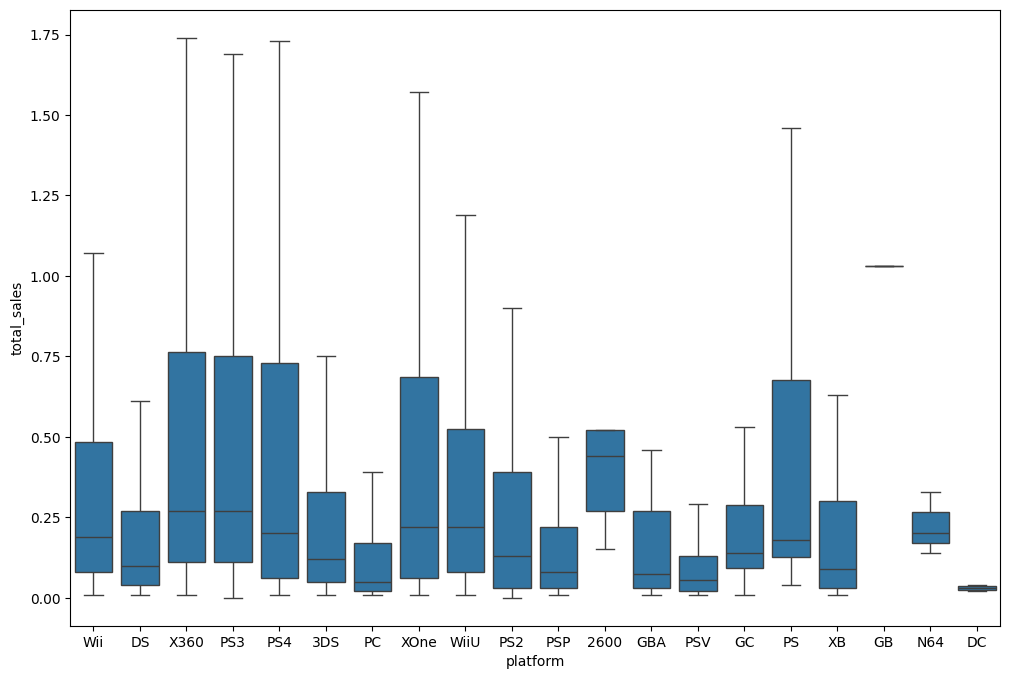

In [30]:
# Adjust size of figure for readability
pt.figure(figsize=(12,8))
# Create boxplot using seaborn and sort by platform
sns.boxplot(x='platform',y='total_sales',data=model_df, showfliers=False)

- 